# 5 Modeling

## 5.1 Imports

In [11]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import tree, metrics

## 5.2 Load Model

In [12]:
expected_model_version = '1.0'
model_path = '../models/credit_card_fraud_detection_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

## 5.3 Load Data

In [19]:
df= pd.read_csv('../Data/step3_features.csv')
test_data= pd.read_csv('../Data/test_data.csv')
train_data= pd.read_csv('../Data/train_data.csv')


In [14]:
df.head()

,account_number,merchant,trans_amount,first_name,last_name,street,city,state,zip,lat,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2703186189652095,"fraud_Rippin, Kub and Mann",4.97,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,28654,36.0788,...,0,0,0,1,0,0,0,0,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",107.23,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,...,0,0,0,0,0,0,0,0,0,0
2,38859492057661,fraud_Lind-Buckridge,220.11,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,83252,42.1808,...,0,0,0,0,0,0,0,0,0,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",45.00,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,...,0,0,0,0,0,0,0,0,0,1
4,375534208663984,fraud_Keeling-Crist,41.96,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,24433,38.4207,...,0,0,0,0,1,0,0,0,0,1


In [20]:
# Use train data from train-test split in the training step to find the best model parameters 

X_train= train_data.drop(columns=['is_fraud'])
y_train= train_data['is_fraud']

In [23]:
#Perform GridSearchCV to find the best model parameters

param_grid = {'max_depth': np.arange(2, 10), 'criterion':['gini', 'entropy'], 'class_weight' : ['balanced']}

model_cv= GridSearchCV(model, param_grid, cv=5 , scoring='recall')


In [24]:
model_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=1234),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='recall')

In [26]:
model_cv.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9}

In [44]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=16)
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average Score', fontsize=12)
    ax.legend(loc="best", fontsize=12)
    ax.grid(False)

# Calling Method 
# plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')


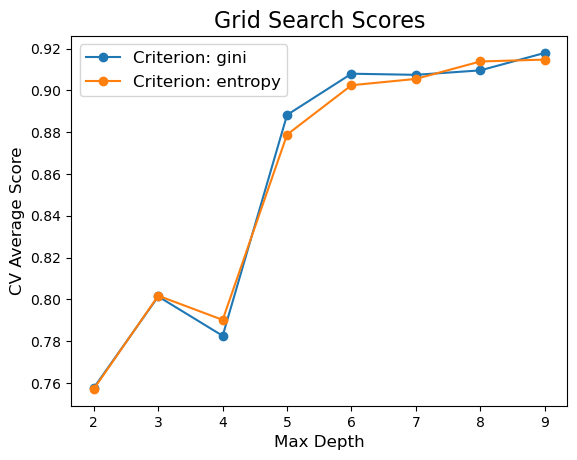

In [45]:
max_depth= np.arange(2, 10)
criterion= ['gini', 'entropy']

plot_grid_search(model_cv.cv_results_, max_depth, criterion, 'Max Depth', 'Criterion')

As we can see, both gini and entropy model perform pretty similar with the gini model performing slightly better. Therefore, the Random Forest with max_depth of 9 and criterion gini could be used as our best model and we can then evaluate the performance onf this model on the test data. 

## 5.5 Predict The Test Data Using The Best Model

In [48]:
# Use test data from train-test split in the training step to evaluate model performance 

X_test= test_data.drop(columns=['is_fraud'])
y_test= test_data['is_fraud']

In [49]:
X_test.shape, y_test.shape

((324169, 28), (324169,))

In [50]:
y_test_pred = model_cv.predict(X_test) 

In [51]:
# model evaluation 
print("Model: RandomForest Model Best Estimator")
print("Accuracy:", metrics.accuracy_score(y_test,y_test_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_test_pred))
print('Precision score:' , metrics.precision_score(y_test,y_test_pred))
print('Recall score:' , metrics.recall_score(y_test,y_test_pred))
print('F1 score:' , metrics.f1_score(y_test,y_test_pred))

Model: RandomForest Model Best Estimator
Accuracy: 0.980047444388575
Balanced accuracy: 0.944149834515398
Precision score: 0.21302662832854108
Recall score: 0.9078316462440064
F1 score: 0.34507897934386395


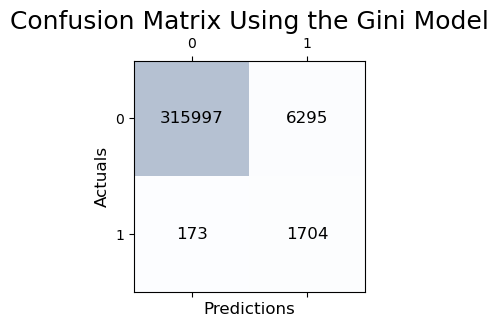

In [54]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size=12)

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title('Confusion Matrix Using the Gini Model', fontsize=18)
plt.show()

In [53]:
fpr= 6295/(6295+315997)
fpr

0.019531977213210382

>Therefore, our random forest model with criterion= gini and max_depth=9 could accurately classify 90% of the fraud transactions. Even though some false positive can be seen in the results, the false positive rate is only about 1.9% which can be negligible since in this case we care more about the false negatives and would like to minimize the number of fraud transactions that mistakely classified as valid transactions. Here, about 10% of the fraud transactions are mistakenly classified as valid transactions. The model can be further improved by doing more feature engineering for example adding more features to calculate the time difference between the transactions and the distance difference using latitude and longitude of the merchant. 